In [178]:
import numpy as np
import matplotlib.pyplot as plt

In [179]:
#Question 1: Interplay between MAC layer and TCP like transport layer
def service(N, K):
    #This is a binomial probability distribution with N trials and K successes
    #The probability of success is K/N
    return np.random.binomial(N, K/N)
def arrival_bernoulli(p):
    #This is a Bernoulli distribution with probability p
    return np.random.choice([0,1], p=[1-p, p])
    

In [180]:
def average_delay_update(i, R, Tn, Dnplusone, n):
    #This is the update equation for the average delay
    #Tn is the previous average delay
    #Dnplusone is the new delay
    if(Tn == 0):
        return Dnplusone
    if(i<R):
        return (Tn*n+Dnplusone)/(n+1)
    return 0.9*Tn + 0.1*Dnplusone

In [181]:
def arrival_general_update(i, p, n, t, T, R, arrival_times, service_times, delta, dropped_times):
    #This is the update equation for the probability of arrival
    #p is the previous probability of arrival
    #n is the number of packets served so far for this flow
    #T is the average delay for this flow
    #arrival_times is the list of arrival times for this flow
    #service_times is the list of service times for this flow
    #This function returns the new probability of arrival
    if n == 0:
        return p
    elif i<R:
        return p
    elif len(arrival_times) > len(service_times):
        if(arrival_times[len(service_times)] <= t - np.ceil(1.2*T)):
            return 2*p/3
    elif len(dropped_times) > 0:
        if dropped_times[0] <= t - np.ceil(1.2*T):
            #remove first element of dropped_times
            dropped_times= dropped_times.pop(0) #count one dropped packet only once
            return 2*p/3
    #for the 2nd case,
    #the first packet served in this time slot should have arrived 
    #at most 1.2*T time slots ago
    else:
        for i in range(len(service_times)):
            if service_times[i] == t:
                if arrival_times[i] > t - np.ceil(1.2*T): #checking if the served packet arrived in the last 1.2*T time slots
                    return min(0.9, p+delta)
                else:
                    break
    return p

In [182]:
N=30
K=20
R=15
T = 1000
p=0.5
alpha = 1.2
#One dimensional array for the number of packets in the queue
queue_size = [0 for i in range(K)]
dropped_packets = [0 for i in range(K)]
q_max = alpha*K*p*p/(1-p) #maximum queue size (buffer size)
#Two dimensional arrays for the arrival times and service times
arrival_times = [[] for i in range(K)]
service_times = [[] for i in range(K)]
dropped_times = [[] for i in range(K)]
#One dimensional arrays for the current average delay and current probability of arrival
average_delay = [0 for i in range(K)]
#probability_of_arrival is p for each flow in the beginning
probability_of_arrival = [p for i in range(K)]
#Two dimensional arrays for the number of packets served 
number_of_packets_served = [[0 for i in range(T)] for j in range(K)]
#One dimensional array for server utilization 
server_utilization = [0 for i in range(T)]

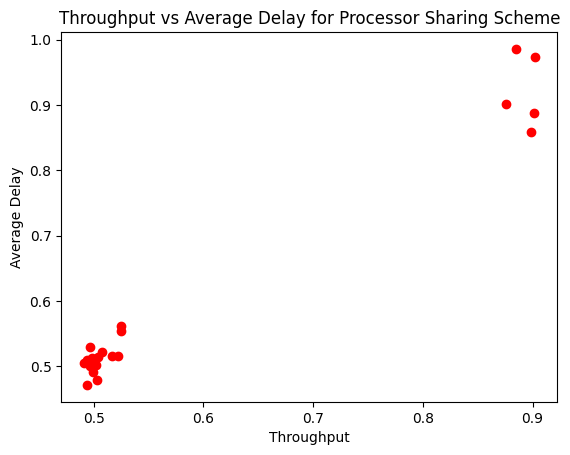

In [183]:
#Scheme 1: Processor Sharing
for t in range(T):
    #defining arrivals
    for i in range(K):
        if(arrival_bernoulli(probability_of_arrival[i])):
            if(queue_size[i] < q_max):
                queue_size[i] += 1 #increment queue size if buffer is not full
                arrival_times[i].append(t)
            else:
                dropped_packets[i] += 1 #increment dropped packets if buffer is full
                dropped_times[i].append(t)
    #total service capacity
    S = service(N, K)
    S_copy = S
    #finding 'l' value as per the scheme:
    for l in range(0,100):
        if(S > l*K and S <= (l+1)*K):
            break

    #servicing
    #serve l packets from each flow first, then serve one additional packet
    #from each flow in a round robin fashion until S packets are served
    for i in range(K):
        for j in range(l):
            if(queue_size[i] > 0):
                service_times[i].append(t)
                queue_size[i] -= 1
                number_of_packets_served[i][t] += 1
                S -= 1
    #round robin
    i=0
    while(S > 0):
        if(queue_size[i] > 0):
            service_times[i].append(t)
            queue_size[i] -= 1
            number_of_packets_served[i][t] += 1
            S -= 1
        i = (i+1)%K 
        if(i == 0):
            break
    #server utilization
    if(S_copy == 0):
        server_utilization[t] = 0
    else:
        server_utilization[t] = (S_copy - S)/S_copy

    #updating average delay and probability of arrival for each flow
    for i in range(K):
        if(number_of_packets_served[i][t] > 0):
            #total packets served so far
            total = 0
            for j in range(t-1):
                total = total + number_of_packets_served[i][j]
            for j in range(number_of_packets_served[i][t]):
                average_delay[i] = average_delay_update(i, R, average_delay[i], t - arrival_times[i][total + j], total+j)
            probability_of_arrival[i] = arrival_general_update(i, probability_of_arrival[i], total, t, average_delay[i], R, arrival_times[i], service_times[i], 0.01, dropped_times[i])

#throughput and average delay for each flow
throughput = [0 for i in range(K)]
for i in range(K):
    throughput[i] = len(service_times[i])/T
#plotting throughput vs average delay
plt.plot(throughput, average_delay, 'ro')
plt.xlabel('Throughput')
plt.ylabel('Average Delay')
plt.title('Throughput vs Average Delay for Processor Sharing Scheme')
plt.show()

throughput_processor_sharing = throughput
average_delay_processor_sharing = average_delay
server_utilization_processor_sharing = server_utilization
dropped_packets_processor_sharing = dropped_packets

In [184]:
#Re-running initialiser code to reset all values
N=30
K=20
R=15
T = 1000
p=0.5
alpha = 1.2
#One dimensional array for the number of packets in the queue
queue_size = [0 for i in range(K)]
dropped_packets = [0 for i in range(K)]
q_max = alpha*K*p*p/(1-p) #maximum queue size (buffer size)
#Two dimensional arrays for the arrival times and service times
arrival_times = [[] for i in range(K)]
service_times = [[] for i in range(K)]
dropped_times = [[] for i in range(K)]
#One dimensional arrays for the current average delay and current probability of arrival
average_delay = [0 for i in range(K)]
#probability_of_arrival is p for each flow in the beginning
probability_of_arrival = [p for i in range(K)]
#Two dimensional arrays for the number of packets served 
number_of_packets_served = [[0 for i in range(T)] for j in range(K)]
#One dimensional array for server utilization 
server_utilization = [0 for i in range(T)]

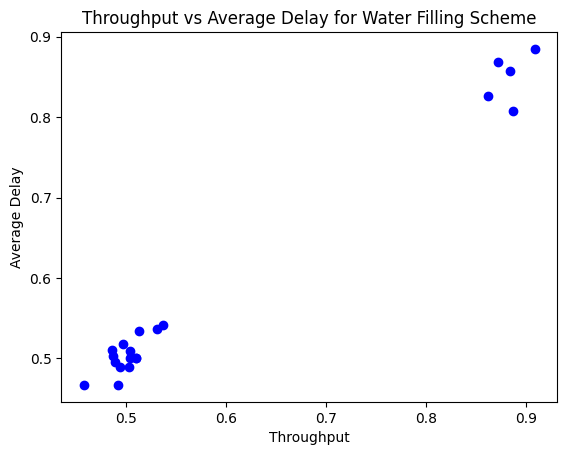

In [185]:
#Scheme 2: Water filling or minimising the max queue
for t in range(T):
    #defining arrivals
    for i in range(K):
        if(arrival_bernoulli(probability_of_arrival[i])):
            if(queue_size[i] < q_max):
                queue_size[i] += 1
                arrival_times[i].append(t)
            else:
                dropped_packets[i] += 1
                dropped_times[i].append(t)
    #total service capacity
    S = service(N, K)
    S_copy = S

    #servicing
    #at each time slot, serve the flow with the maximum queue size
    while(S>0):
        #finding the flow with the maximum queue size
        max_queue = 0
        for j in range(K):
            if(queue_size[j] > max_queue):
                max_queue = queue_size[j]
                max_flow = j
        #serving the flow with the maximum queue size
        if(max_queue == 0):
            break
        service_times[max_flow].append(t)
        queue_size[max_flow] -= 1
        number_of_packets_served[max_flow][t] += 1
        S -= 1

    #server utilization
    if(S_copy == 0):
        server_utilization[t] = 0
    else:
        server_utilization[t] = (S_copy - S)/S_copy

    #updating average delay and probability of arrival for each flow
    for i in range(K):
        if(number_of_packets_served[i][t] > 0):
            #total packets served so far
            total = 0
            for j in range(t-1):
                total = total + number_of_packets_served[i][j]
            for j in range(number_of_packets_served[i][t]):
                average_delay[i] = average_delay_update(i, R, average_delay[i], t - arrival_times[i][total + j], total+j)
            probability_of_arrival[i] = arrival_general_update(i, probability_of_arrival[i], total, t, average_delay[i], R, arrival_times[i], service_times[i], 0.01, dropped_times[i])

#throughput and average delay for each flow
throughput = [0 for i in range(K)]
for i in range(K):
    throughput[i] = len(service_times[i])/T
#plotting throughput vs average delay
plt.plot(throughput, average_delay, 'bo')
plt.xlabel('Throughput')
plt.ylabel('Average Delay')
plt.title('Throughput vs Average Delay for Water Filling Scheme')
plt.show()

throughput_water_filling = throughput
average_delay_water_filling = average_delay
server_utilization_water_filling = server_utilization
dropped_packets_water_filling = dropped_packets


In [186]:
#Re-running initialiser code to reset all values
N=30
K=20
R=15
T = 1000
p=0.5
alpha = 1.2
#One dimensional array for the number of packets in the queue
queue_size = [0 for i in range(K)]
dropped_packets = [0 for i in range(K)]
q_max = alpha*K*p*p/(1-p) #maximum queue size (buffer size)
#Two dimensional arrays for the arrival times and service times
arrival_times = [[] for i in range(K)]
service_times = [[] for i in range(K)]
dropped_times = [[] for i in range(K)]
#One dimensional arrays for the current average delay and current probability of arrival
average_delay = [0 for i in range(K)]
#probability_of_arrival is p for each flow in the beginning
probability_of_arrival = [p for i in range(K)]
#Two dimensional arrays for the number of packets served 
number_of_packets_served = [[0 for i in range(T)] for j in range(K)]
#One dimensional array for server utilization 
server_utilization = [0 for i in range(T)]

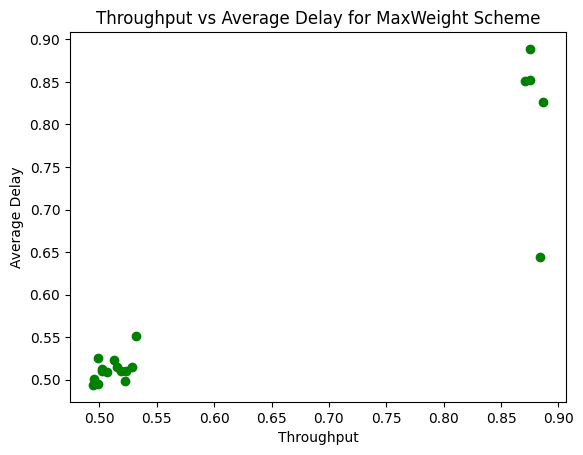

In [187]:
#Scheme 3: MaxWeight
for t in range(T):
    #defining arrivals
    for i in range(K):
        if(arrival_bernoulli(probability_of_arrival[i])):
            if(queue_size[i] < q_max):
                queue_size[i] += 1
                arrival_times[i].append(t)
            else:
                dropped_packets[i] += 1
                dropped_times[i].append(t)
    #total service capacity
    S = service(N, K)
    S_copy = S

    #servicing
    #at each time slot, give all S slots to the flow with the maximum weight (queue size)
    while(S>0):
        #finding the flow with the maximum queue size
        max_queue = 0
        for j in range(K):
            if(queue_size[j] > max_queue):
                max_queue = queue_size[j]
                max_flow = j
        if(max_queue == 0):
            break
        for i in range(max_queue):
            if(S == 0):
                break
            service_times[max_flow].append(t)
            queue_size[max_flow] -= 1
            number_of_packets_served[max_flow][t] += 1
            S -= 1
    
    #server utilization
    if(S_copy == 0):
        server_utilization[t] = 0
    else:
        server_utilization[t] = (S_copy - S)/S_copy
    
    #updating average delay and probability of arrival for each flow
    for i in range(K):
        if(number_of_packets_served[i][t] > 0):
            #total packets served so far
            total = 0
            for j in range(t-1):
                total = total + number_of_packets_served[i][j]
            for j in range(number_of_packets_served[i][t]):
                average_delay[i] = average_delay_update(i, R, average_delay[i], t - arrival_times[i][total + j], total+j)
            probability_of_arrival[i] = arrival_general_update(i, probability_of_arrival[i], total, t, average_delay[i], R, arrival_times[i], service_times[i], 0.01, dropped_times[i])
                            
    
#throughput and average delay for each flow
throughput = [0 for i in range(K)]
for i in range(K):
    throughput[i] = len(service_times[i])/T
#plotting throughput vs average delay
plt.plot(throughput, average_delay, 'go')
plt.xlabel('Throughput')
plt.ylabel('Average Delay')
plt.title('Throughput vs Average Delay for MaxWeight Scheme')
plt.show()

throughput_max_weight = throughput
average_delay_max_weight = average_delay
server_utilization_max_weight = server_utilization
dropped_packets_max_weight = dropped_packets


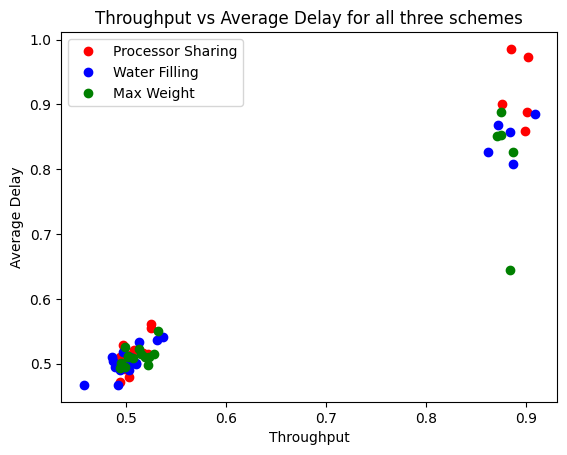

In [188]:
#Plotting throughputs of all three schemes on the same graph
plt.plot(throughput_processor_sharing, average_delay_processor_sharing, 'ro', label = 'Processor Sharing')
plt.plot(throughput_water_filling, average_delay_water_filling, 'bo', label = 'Water Filling')
plt.plot(throughput_max_weight, average_delay_max_weight, 'go', label = 'Max Weight')
plt.xlabel('Throughput')
plt.ylabel('Average Delay')
plt.title('Throughput vs Average Delay for all three schemes')
plt.legend()
plt.show()


In [189]:
#Comparing throughput and average delay for all three schemes for a particular flow
pipe = 17
print("Throughput for flow", pipe, "for Processor Sharing Scheme:", throughput_processor_sharing[pipe-1])
print("Average Delay for flow", pipe, "for Processor Sharing Scheme:", average_delay_processor_sharing[pipe-1])
print("Throughput for flow", pipe, "for Water Filling Scheme:", throughput_water_filling[pipe-1])
print("Average Delay for flow", pipe, "for Water Filling Scheme:", average_delay_water_filling[pipe-1])
print("Throughput for flow", pipe, "for Max Weight Scheme:", throughput_max_weight[pipe-1])
print("Average Delay for flow", pipe, "for Max Weight Scheme:", average_delay_max_weight[pipe-1])



Throughput for flow 17 for Processor Sharing Scheme: 0.899
Average Delay for flow 17 for Processor Sharing Scheme: 0.8587248538005512
Throughput for flow 17 for Water Filling Scheme: 0.909
Average Delay for flow 17 for Water Filling Scheme: 0.8846585072599792
Throughput for flow 17 for Max Weight Scheme: 0.875
Average Delay for flow 17 for Max Weight Scheme: 0.8888401255915998


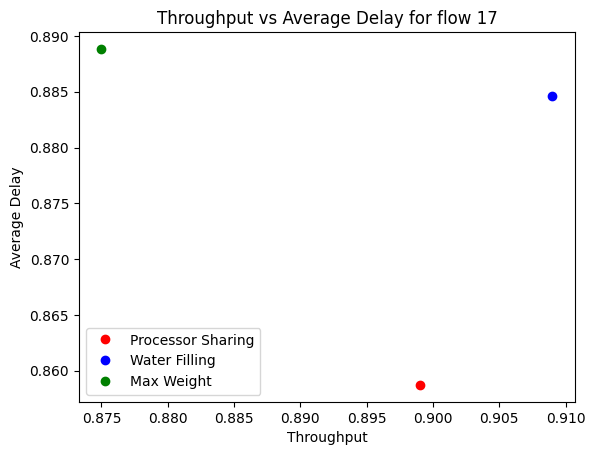

In [190]:
#Plotting throughput vs average delay for all three schemes for a particular flow
plt.plot(throughput_processor_sharing[pipe-1], average_delay_processor_sharing[pipe-1], 'ro', label = 'Processor Sharing')
plt.plot(throughput_water_filling[pipe-1], average_delay_water_filling[pipe-1], 'bo', label = 'Water Filling')
plt.plot(throughput_max_weight[pipe-1], average_delay_max_weight[pipe-1], 'go', label = 'Max Weight')
plt.xlabel('Throughput')
plt.ylabel('Average Delay')
plt.title('Throughput vs Average Delay for flow ' + str(pipe))
plt.legend()
plt.show()

In [191]:
#comparing average server utilization for all three schemes in percentage
print("Average server utilization for Processor Sharing Scheme in percentage:", np.mean(server_utilization_processor_sharing)*100)
print("Average server utilization for Water Filling Scheme in percentage:", np.mean(server_utilization_water_filling)*100)
print("Average server utilization for Max Weight Scheme in percentage:", np.mean(server_utilization_max_weight)*100)


Average server utilization for Processor Sharing Scheme in percentage: 60.75609993221034
Average server utilization for Water Filling Scheme in percentage: 60.84549606790437
Average server utilization for Max Weight Scheme in percentage: 61.106587112718536


In [192]:
#Number of packets dropped for each flow for all three schemes
print("Number of packets dropped for each flow for Processor Sharing Scheme:", dropped_packets_processor_sharing)
print("Number of packets dropped for each flow for Water Filling Scheme:", dropped_packets_water_filling)
print("Number of packets dropped for each flow for Max Weight Scheme:", dropped_packets_max_weight)

Number of packets dropped for each flow for Processor Sharing Scheme: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of packets dropped for each flow for Water Filling Scheme: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of packets dropped for each flow for Max Weight Scheme: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
